# Testing RNN models to predict charging demand at an EV charging station

#### Import packages

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from plot_utils import plot_series
from data_handler import load_dataset
from sklearn.preprocessing import MinMaxScaler

#### Load and prepare the dataset

In [5]:
dataset = "ACN_data"
series,times = load_dataset(dataset)

scaler = MinMaxScaler(feature_range=(0.1, 1)) #Also try QuantileTransformer
series_scaled = scaler.fit_transform(series)

split_time = int(len(times) * 0.66)


time_test = times[split_time:]
x_test = series[split_time:] # No scaled
x_test_scaled = series_scaled[split_time:]

## 1. Load the model

In [6]:
model = tf.keras.models.load_model('Results/train_Simple_ANN_ws96_epochs2_results/Simple_ANN_ws96_epochs2_model.h5')

2022-05-22 11:31:13.404698: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/curro/opt/anaconda3/lib/python3.8/site-packages/keras/layers/core/lambda_layer.py:297: UserWarning: model_utils is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


#### Specify model parameters

In [7]:
window_size = 24 * 4 # 4 days
num_features = 1

future = 24

## 2. Forecast test values

Modify the starting point to forecast future values

In [8]:
start = 0 #48

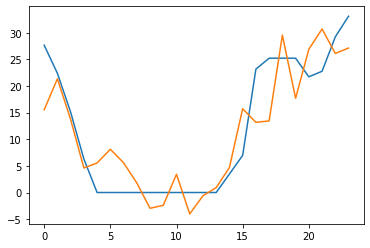

In [9]:
prediction=[]
current_batch = x_test_scaled[start : start + window_size]
current_batch = current_batch.reshape(1, window_size, num_features) #Reshape

# Predict future
for i in range(future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# Inverse transform to before scaling so we get actual values
rescaled_prediction = scaler.inverse_transform(prediction)

# Plot results
plt.figure()
plt.plot(x_test[start + window_size: start + window_size + future])
plt.plot(rescaled_prediction)
plt.show()

#### Forecast more than one time

Modify the starting point to forecast future values and the number of forecasting inferences to be made 

In [10]:
from model_utils import test_forecast

start_all  = 0
num_inferences = 4

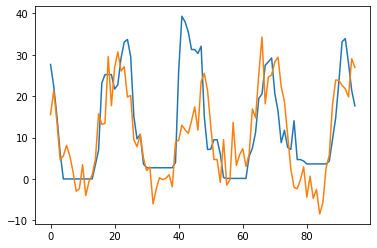

In [12]:
test_forecast(x_test,
              x_test_scaled,
              model,
              scaler,
              window_size,
              num_features,
              future,
              num_inferences,
              start_all)

## 3. Proof of concept: Real time simulation

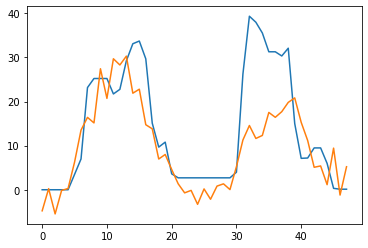

In [14]:
import cv2
from IPython.display import clear_output

start_all=0
num = 10

idx=0
while idx < num:
    num_inferences = 2
    clear_output(wait=True)
    test_forecast(x_test, x_test_scaled, model, scaler, window_size, num_features, future, num_inferences, start_all)
    cv2.waitKey(1)
    start_all  += 1
    idx+=1



## 4. Models comparison (BETA)

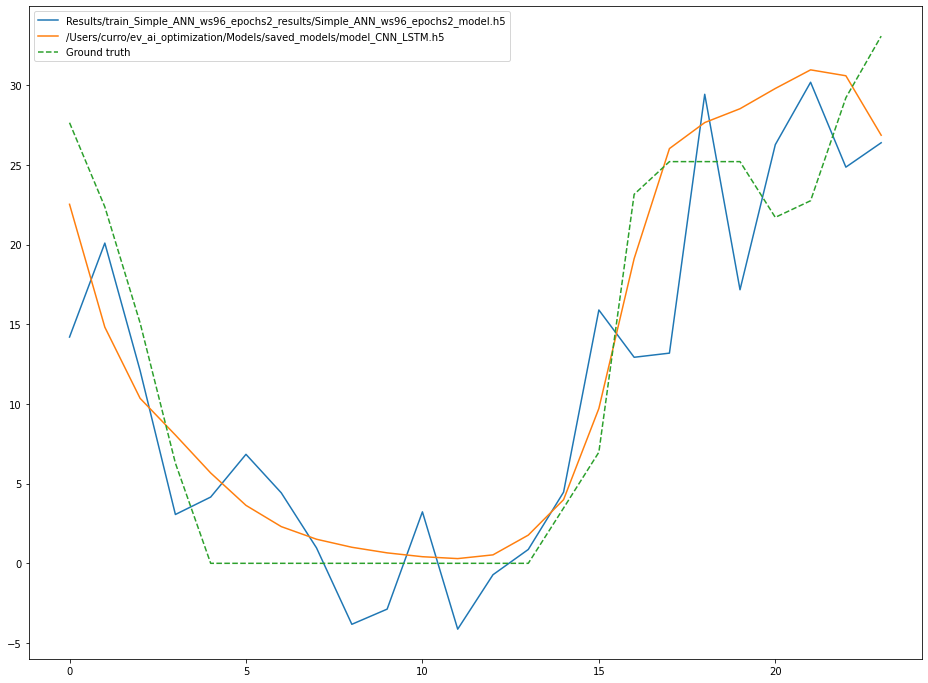

In [ ]:
start = 0 #0 12 24 48

model_names = ['Results/train_Simple_ANN_ws96_epochs2_results/Simple_ANN_ws96_epochs2_model.h5',
               '/Users/curro/ev_ai_optimization/Models/saved_models/model_CNN_LSTM.h5'
              ]
plt.figure(figsize=(16, 12))
for model_name in model_names:
    model = tf.keras.models.load_model(model_name)
    
    prediction=[]
    current_batch = x_test_scaled[start : start + window_size]
    current_batch = current_batch.reshape(1, window_size, num_features) #Reshape
    
    # Predict future
    for i in range(future):
        current_pred = model.predict(current_batch)[0]
        prediction.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    # Inverse transform to before scaling so we get actual values
    rescaled_prediction = scaler.inverse_transform(prediction)
    
    plt.plot(rescaled_prediction)

plt.plot(x_test[start + window_size: start + window_size + future],'--' )
model_names.append('Ground truth')
plt.legend(model_names)
plt.show()